# Textbook and Shor's algorithms

Qiskit contains implementations of the well known textbook quantum algorithms such as the [Deutsch-Jozsa algorithm](https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html), the [Bernstein-Vazirani algorithm](https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html) and [Simon's algorithm](https://qiskit.org/textbook/ch-algorithms/simon.html).

Qiskit also has an implementation of [Shor's algorithm](https://qiskit.org/textbook/ch-algorithms/shor.html).

The preceding references have detailed explanations and build-out of circuits whereas this notebook has examples with the pre-built algorithms in Qiskit that you can use for experimentation and education purposes.

In [1]:
import math
import numpy as np
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import BernsteinVazirani, DeutschJozsa, Simon, Shor
from qiskit.aqua.components.oracles import TruthTableOracle

## Deutsch-Jozsa algorithm

Lets start with the [Deutsch-Jozsa algorithm](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.DeutschJozsa.html) which can determine if a function is `'balanced'` or `'constant'` given such a function as input. We can experiment with it in Qiskit using an oracles created from a truth tables. So for example, we can create a `TruthTableOracle` instance as follows.

In [2]:
bitstr = '11110000'
oracle = TruthTableOracle(bitstr)

As shown, the truthtable is specified with the `bitstr` containing values of all entries in the table. It has length $8$, so the corresponding truth table is of $3$ input bits. We can of course see that this truth table represents a `'balanced'` function as half of values are $1$ and the other half $0$.

It might seem like a moot point running Deutsch-Jozsa on a truthtable as the function outputs are literally listed as the truthtable's values. The intention is to create an oracle circuit whose groundtruth information is readily available to us but obviously not to the quantum Deutsch-Jozsa algorithm that is to act upon the oracle circuit. In more realistic situations, the oracle circuit would be provided as a blackbox to the algorithm.

Above said, we can inspect the circuit corresponding to the function encoded in the `TruthTableOracle` instance.

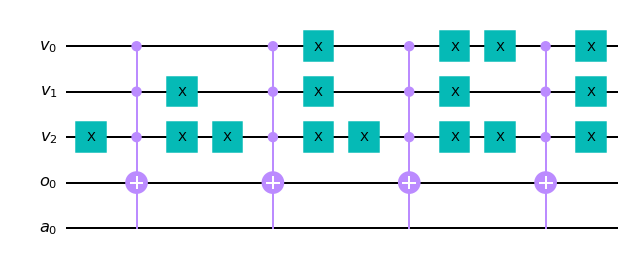

In [3]:
oracle.circuit.draw(output='mpl')

As seen, the $v_i$'s correspond to the 3 input bits; the $o_0$ is the oracle's output qubit; the $a_0$ is an ancilla qubit.

Next we can simply create a `DeutschJozsa` instance using the oracle, and run it to check the result.

In [4]:
dj = DeutschJozsa(oracle)
backend = BasicAer.get_backend('qasm_simulator')
result = dj.run(QuantumInstance(backend, shots=1024))
print(f'The truth table {bitstr} represents a \'{result["result"]}\' function.')

The truth table 11110000 represents a 'balanced' function.


We can of course quickly put together another example for a `'constant'` function, as follows.

In [5]:
bitstr = '1' * 16
oracle = TruthTableOracle(bitstr)
dj = DeutschJozsa(oracle)
backend = BasicAer.get_backend('qasm_simulator')
result = dj.run(QuantumInstance(backend, shots=1024))
print(f'The truth table {bitstr} represents a \'{result["result"]}\' function.')

The truth table 1111111111111111 represents a 'constant' function.


## Bernstein-Vazirani algorithm

Next the [Bernstein-Vazirani algorithm](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.BernsteinVazirani.html) which tries to find a hidden string. Again, for the example, we create a TruthTableOracle instance.

In [6]:
bitstr = '00111100'
oracle = TruthTableOracle(bitstr)

As shown, the truthtable is specified with the `bitstr` containing values of all entries in the table. It has length $8$, so the corresponding truth table is of $3$ input bits. The truthtable represents the function mappings as follows:

- $\mathbf{a} \cdot 000 \mod 2 = 0$
- $\mathbf{a} \cdot 001 \mod 2 = 0$
- $\mathbf{a} \cdot 010 \mod 2 = 1$
- $\mathbf{a} \cdot 011 \mod 2 = 1$
- $\mathbf{a} \cdot 100 \mod 2 = 1$
- $\mathbf{a} \cdot 101 \mod 2 = 1$
- $\mathbf{a} \cdot 110 \mod 2 = 0$
- $\mathbf{a} \cdot 111 \mod 2 = 0$

And obviously the goal is to find the bitstring $\mathbf{a}$ that satisfies all the inner product equations.

Lets again look at the oracle circuit, that now corresponds to the binary function encoded in the `TruthTableOracle` instance.

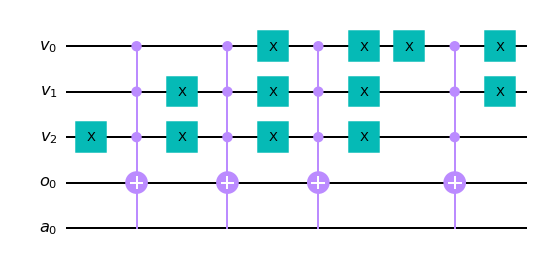

In [7]:
oracle.circuit.draw(output='mpl')

Again the $v_i$'s correspond to the 3 input bits; the $o_0$ is the oracle's output qubit; the $a_0$ is an ancilla qubit.

Let us first compute the groundtruth $\mathbf{a}$ classically:

In [8]:
a_bitstr = ""
num_bits = math.log2(len(bitstr))
for i in reversed(range(3)):
    bit = bitstr[2 ** i]
    a_bitstr += bit
print(f'The groundtruth result bitstring is {a_bitstr}.')

The groundtruth result bitstring is 110.


Next we can create a `BernsteinVazirani` instance using the oracle, and run it to check the result against the groundtruth.

In [9]:
bv = BernsteinVazirani(oracle)
backend = BasicAer.get_backend('qasm_simulator')
result = bv.run(QuantumInstance(backend, shots=1024))
print(f'The result bitstring computed using Bernstein-Vazirani is {result["result"]}.')
assert(result['result'] == a_bitstr)

The result bitstring computed using Bernstein-Vazirani is 110.


## Simon's algorithm

[Simon's algorithm](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.Simon.html) is used to solve [Simon's problem](https://en.wikipedia.org/wiki/Simon's_problem). Once again, for the example, we create a TruthTableOracle instance, where the construction shows a different form.

In [10]:
bitmaps = [
    '01101001', 
    '10011001', 
    '01100110'
]
oracle = TruthTableOracle(bitmaps)

As shown, the truthtable is specified with three length-8 bitstrings, each containing the values of all entries for a particular output column in the table. Each bitstring has length $8$, so the truthtable has $3$ input bits; There are $3$ bitstrings, so the truthtable has $3$ output bits.

The function $f$ represented by the truthtable is promised to be either 1-to-1 or 2-to-1. Our goal is to determine which. For the case of 2-to-1, we also need to compute the mask $\mathbf{s}$, which satisfies $\forall \mathbf{x},\mathbf{y}$: $\mathbf{x} \oplus \mathbf{y} = \mathbf{s}$ iff $f(\mathbf{x}) = f(\mathbf{y})$. Apparently, if $f$ is 1-to-1, the corresponding mask $\mathbf{s} = \mathbf{0}$.

Let us first compute the groundtruth mask $\mathbf{s}$ classically:

In [11]:
def compute_mask(input_bitmaps):
    vals = list(zip(*input_bitmaps))[::-1]
    def find_pair():
        for i in range(len(vals)):
            for j in range(i + 1, len(vals)):
                if vals[i] == vals[j]:
                    return i, j
        return 0, 0

    k1, k2 = find_pair()
    return np.binary_repr(k1 ^ k2, int(np.log2(len(input_bitmaps[0]))))

mask = compute_mask(bitmaps)
print(f'The groundtruth mask is {mask}.')

The groundtruth mask is 011.


In [12]:
simon = Simon(oracle)
backend = BasicAer.get_backend('qasm_simulator')
result = simon.run(QuantumInstance(backend, shots=1024))
print(f'The mask computed using Simon is {result["result"]}.')
assert(result['result'] == mask)

The mask computed using Simon is 011.


We can also quickly try a truthtable that represents a 1-to-1 function (i.e., the corresponding mask is $\mathbf{0}$), as follows.

In [13]:
bitmaps = [
    '00011110', 
    '01100110', 
    '10101010'
]
mask = compute_mask(bitmaps)
print(f'The groundtruth mask is {mask}.')

oracle = TruthTableOracle(bitmaps)
simon = Simon(oracle)
result = simon.run(QuantumInstance(backend, shots=1024))
print(f'The mask computed using Simon is {result["result"]}.')
assert(result['result'] == mask)

The groundtruth mask is 000.
The mask computed using Simon is 000.


## Shor's Factoring algorithm

[Shor’s Factoring algorithm](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.Shor.html) is one of the most well-known quantum algorithms and finds the prime factors for input integer $N$ in polynomial time. The algorithm implementation in Qiskit is simply provided a target integer to be factored and run, as follows:

In [14]:
N = 15
shor = Shor(N)
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
result = shor.run(quantum_instance)
print(f"The list of factors of {N} as computed by the Shor's algorithm is {result['factors'][0]}.")

The list of factors of 15 as computed by the Shor's algorithm is [3, 5].


Note: this implementation of Shor's algorithm uses $4n + 2$ qubits, where $n$ is the number of bits representing the integer in binary. So in practice, for now, this implementation is restricted to factorizing small integers. Given the above value of N we compute $4n +2$ below and confirm the size from the actual circuit.

In [15]:
print(f'Computed of qubits for circuit: {4 * math.ceil(math.log(N, 2)) + 2}')
print(f'Actual number of qubits of circuit: {shor.construct_circuit().num_qubits}')

Computed of qubits for circuit: 18
Actual number of qubits of circuit: 18


In [16]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright